<a href="https://colab.research.google.com/github/ujjwalbb30/CMSC_678_ASL_image_classification_ML/blob/main/python_notebooks/Part_2_CNN_Swish_ASL_Image_Classification_Ujjwal_PF10610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifiying American Sign Language (ASL) images using Covolutional Neural Network (CNN) models**
# **Activation Function : 'swish'**

In this notebook, I will be training 10 different CNN models to classify ASL images. I will mainly use 'swish' activation function in the hidden layers. I will be conducting following experiments in this notebook:

▶ 5 different CNN models (with 1 Convolutional layer, 1 MaxPooling layer and 1 Dropout Layer) will be trained with following kernel sizes:

>(a) (4,4)

>(b) (5,5)

>(c) (6,6)

>(d) (7,7)

>(e) (8,8)

▶ For each kernel size mentioned above, 1 more type of CNN model (having the following characteristics), will be trained:

>(a) 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers

▶ In total, 10 models will be trained and following metrics will be calculated for each model along with Confusion matrix:

> (a) Accuracy

> (b) Precision

> (c) Recall

> (d) F1-score

## **Importing required libraries and data**

In [ ]:
# installing split-folders library to split the images dataset folders into training, validation and testing folders
!pip install split-folders

###**Importing required libraries**

In [ ]:
# importing required dependencies

# importing pandas, numpy, random, matplotlib and their required modules
import pandas as pd
import numpy as np
import random
from numpy.random import seed
seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# importing tensorflow, keras and their required modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam

# importing sklearn and their required modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# importing other required libraries
import glob
import cv2
import skimage
from skimage.transform import resize
import os
import gc

import splitfolders

###**Mounting the drive and copying the data to allocated machine**

In [ ]:
# mounting the drive to access data files
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# defining the path of data in drive (path to copy the data from)
# defining the path where the data should be copied
drive_path = '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset'
local_path = '/content'

# copying the data from drive to machine
!cp -av '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset' '/content'

Streaming output truncated to the last 5000 lines.
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1898.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1898.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1904.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1904.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1890.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1890.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1880.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1880.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1908.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1908.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1888.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1888.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1876.jpg' -> '/content/dataset/asl_alphabet_tr

###**Defining the swish activation function**

In [ ]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

###**Splitting the images dataset folder into train, validation and test images**
###**creating train, validation and test dataframes of image paths and labels**

In [ ]:
# splitting the folder intro training, validation and test dataset
splitfolders.ratio("/content/dataset/asl_alphabet_train", output="/content/dataset/split_dataset", seed=42, ratio=(.7, .1, .2), group_prefix=None)

Copying files: 87020 files [00:12, 6798.08 files/s]


In [ ]:
# Exploring the new created split dataset folder
dataset_folder_path = '/content/dataset/split_dataset'
for path, directories, files in os.walk(dataset_folder_path):
    print(path,'--> number of files : ', len(files))

/content/dataset/split_dataset --> number of files :  0
/content/dataset/split_dataset/test --> number of files :  0
/content/dataset/split_dataset/test/I --> number of files :  602
/content/dataset/split_dataset/test/B --> number of files :  600
/content/dataset/split_dataset/test/K --> number of files :  600
/content/dataset/split_dataset/test/M --> number of files :  600
/content/dataset/split_dataset/test/A --> number of files :  600
/content/dataset/split_dataset/test/F --> number of files :  600
/content/dataset/split_dataset/test/W --> number of files :  600
/content/dataset/split_dataset/test/Z --> number of files :  600
/content/dataset/split_dataset/test/U --> number of files :  600
/content/dataset/split_dataset/test/J --> number of files :  600
/content/dataset/split_dataset/test/nothing --> number of files :  600
/content/dataset/split_dataset/test/R --> number of files :  600
/content/dataset/split_dataset/test/L --> number of files :  600
/content/dataset/split_dataset/t

In [ ]:
# Preparing train, validation and test dataframes of image paths and labels

# defining the path to train, validation and test images data folders
train_dataset_folder = '/content/dataset/split_dataset/train'
validation_dataset_folder = '/content/dataset/split_dataset/val'
test_dataset_folder = '/content/dataset/split_dataset/test'

# initializing empty lists to store paths and labels of train, validation and test images
train_data = []
val_data = []
test_data = []

# saving train images paths and labels
for folder in os.listdir(train_dataset_folder):
    label_folder = os.path.join(train_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    train_data += onlyfiles

# saving validation images paths and labels
for folder in os.listdir(validation_dataset_folder):
    label_folder = os.path.join(validation_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    val_data += onlyfiles

# saving test images paths and labels
for folder in os.listdir(test_dataset_folder):
    label_folder = os.path.join(test_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    test_data += onlyfiles

# creating dataframes from the lists
train_data_df = pd.DataFrame(train_data)
val_data_df = pd.DataFrame(val_data)
test_data_df = pd.DataFrame(test_data)

# viewing the details of training dataframe
print('training data:\n')
display(train_data_df)
print('\nunique labels:\n',train_data_df['label'].unique())
print('\n number of unique labels:\n',train_data_df['label'].nunique())

# viewing the details of validation dataframe
print('\nvalidation data:\n')
display(val_data_df)
print('\nunique labels:\n',val_data_df['label'].unique())
print('\n number of unique labels:\n',val_data_df['label'].nunique())

# viewing the details of testing dataframe
print('\ntesting data:\n')
display(test_data_df)
print('\nunique labels:\n',test_data_df['label'].unique())
print('\n number of unique labels:\n',test_data_df['label'].nunique())

training data:



label                                              path
0         I  /content/dataset/split_dataset/train/I/I2242.jpg
1         I  /content/dataset/split_dataset/train/I/I1159.jpg
2         I   /content/dataset/split_dataset/train/I/I512.jpg
3         I  /content/dataset/split_dataset/train/I/I1000.jpg
4         I  /content/dataset/split_dataset/train/I/I2856.jpg
...     ...                                               ...
60909     P   /content/dataset/split_dataset/train/P/P216.jpg
60910     P  /content/dataset/split_dataset/train/P/P2255.jpg
60911     P   /content/dataset/split_dataset/train/P/P569.jpg
60912     P   /content/dataset/split_dataset/train/P/P878.jpg
60913     P  /content/dataset/split_dataset/train/P/P1606.jpg

[60914 rows x 2 columns]


unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29

validation data:



label                                            path
0        I   /content/dataset/split_dataset/val/I/I301.jpg
1        I  /content/dataset/split_dataset/val/I/I2355.jpg
2        I  /content/dataset/split_dataset/val/I/I1761.jpg
3        I  /content/dataset/split_dataset/val/I/I2032.jpg
4        I   /content/dataset/split_dataset/val/I/I696.jpg
...    ...                                             ...
8697     P  /content/dataset/split_dataset/val/P/P2932.jpg
8698     P  /content/dataset/split_dataset/val/P/P2612.jpg
8699     P  /content/dataset/split_dataset/val/P/P1073.jpg
8700     P  /content/dataset/split_dataset/val/P/P1388.jpg
8701     P    /content/dataset/split_dataset/val/P/P50.jpg

[8702 rows x 2 columns]


unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29

testing data:



label                                             path
0         I  /content/dataset/split_dataset/test/I/I1856.jpg
1         I   /content/dataset/split_dataset/test/I/I525.jpg
2         I   /content/dataset/split_dataset/test/I/I636.jpg
3         I  /content/dataset/split_dataset/test/I/I1972.jpg
4         I   /content/dataset/split_dataset/test/I/I423.jpg
...     ...                                              ...
17399     P  /content/dataset/split_dataset/test/P/P1895.jpg
17400     P   /content/dataset/split_dataset/test/P/P822.jpg
17401     P   /content/dataset/split_dataset/test/P/P656.jpg
17402     P    /content/dataset/split_dataset/test/P/P42.jpg
17403     P  /content/dataset/split_dataset/test/P/P1160.jpg

[17404 rows x 2 columns]


unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


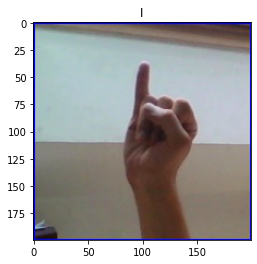

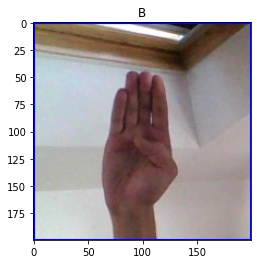

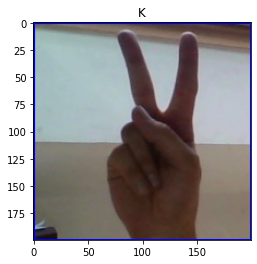

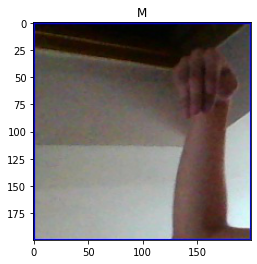

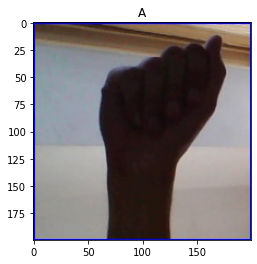

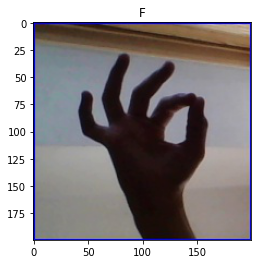

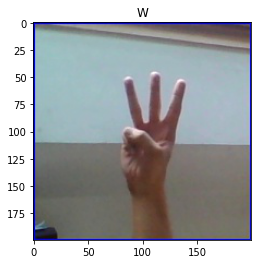

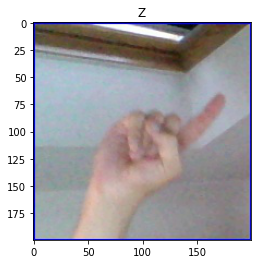

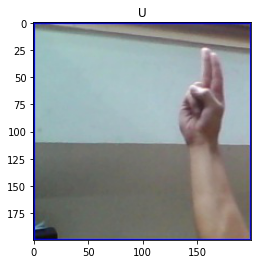

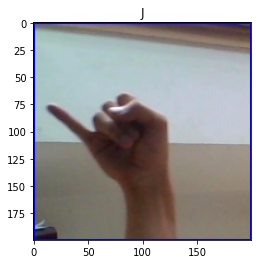

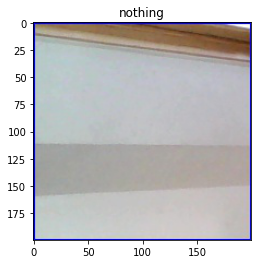

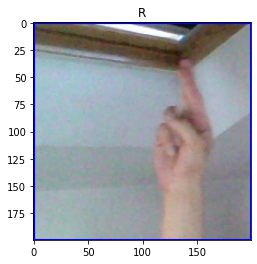

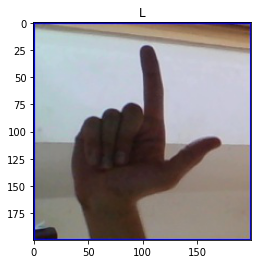

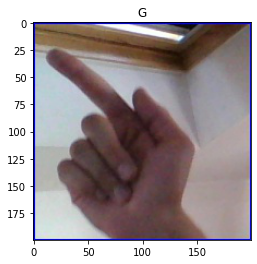

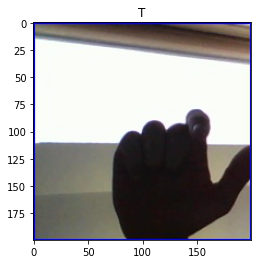

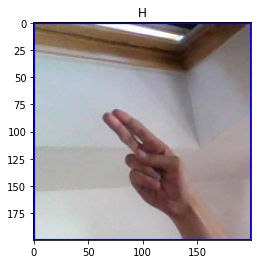

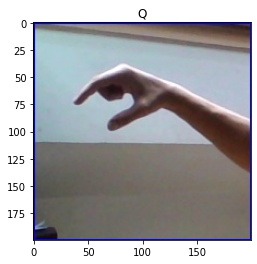

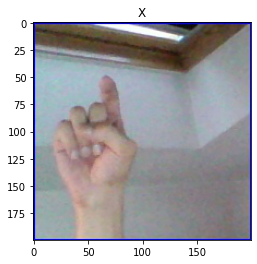

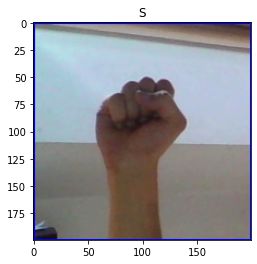

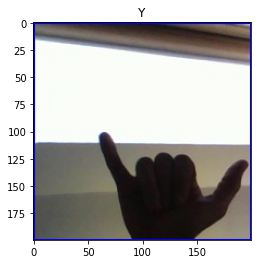

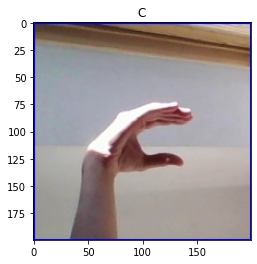

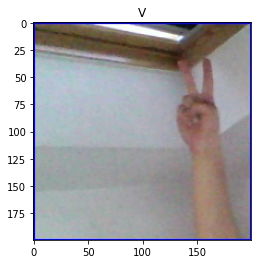

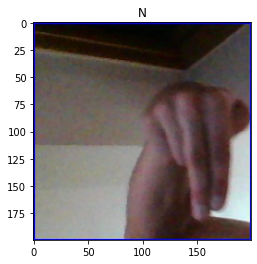

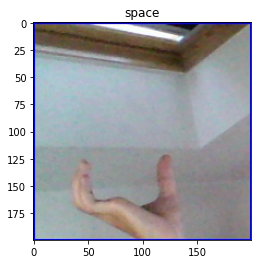

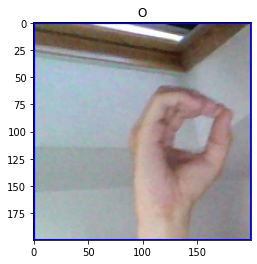

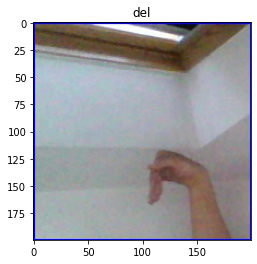

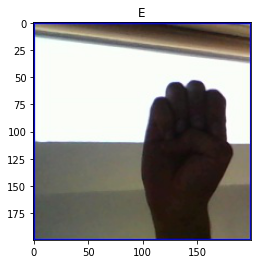

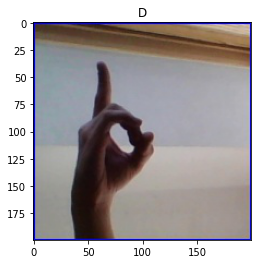

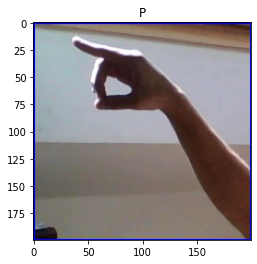

In [ ]:
# viewing random images of each label from train dataframe

unique_asl_signs = train_data_df['label'].unique().tolist()
images = []

for sign in unique_asl_signs:
    rows = train_data_df[train_data_df['label']==sign]['path']
    random_pick = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[random_pick]
    img = mpimg.imread(filepath)
    plt.figure()
    plt.title(sign)
    plt.imshow(img)

In [ ]:
# viewing number of images in train dataset, validation dataset and test dataset
print(f'training data size: {len(train_data_df)}')
print(f'validation data size: {len(val_data_df)}')
print(f'testing data size: {len(test_data_df)}')

training data size: 60914
validation data size: 8702
testing data size: 17404


###**Creating image data generators for train, validation and test image dataset to feed the images to training models in batches**

In [ ]:
# creating image data generators

# defining image dimensions, batch size, target size of image, target dimensions and number of labels
img_dim = 64
batch_size = 64
target_size = (img_dim, img_dim)
target_dims = (img_dim, img_dim, 3)
num_classes = len(train_data_df['label'].unique())

# images are normalized, but not augmented

# train image generator
train_datagen = ImageDataGenerator(rescale = 1/255.0)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data_df,x_col='path', y_col='label', target_size=(img_dim, img_dim),class_mode='categorical', batch_size=batch_size, shuffle=False)

# validation image generator
validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(dataframe=val_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)

# testing image generator
test_datagen = ImageDataGenerator(rescale = 1/255.0)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)


Found 60914 validated image filenames belonging to 29 classes.
Found 8702 validated image filenames belonging to 29 classes.
Found 17404 validated image filenames belonging to 29 classes.


## **CNN Models with 1 Convolutional layer, 1 Maxpooling layer and 1 Dropout layer**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_1l = Sequential()

model_1_1l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_1l.add(Activation('relu'))
model_1_1l.add(MaxPooling2D((2, 2)))
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Flatten())
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Dense(128, activation='swish'))

model_1_1l.add(Dense(num_classes, activation='softmax'))

model_1_1l.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 activation_7 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_13 (Dropout)        (None, 28800)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 83s 87ms/step - loss: 3.0733 - accuracy: 0.1560 - val_loss: 2.1088 - val_accuracy: 0.4016
Epoch 2/10
952/952 [==============================] - 93s 97ms/step - loss: 1.7913 - accuracy: 0.4595 - val_loss: 1.3342 - val_accuracy: 0.5899
Epoch 3/10
952/952 [==============================] - 85s 89ms/step - loss: 1.0930 - accuracy: 0.6503 - val_loss: 0.7066 - val_accuracy: 0.7909
Epoch 4/10
952/952 [==============================] - 91s 95ms/step - loss: 0.7561 - accuracy: 0.7517 - val_loss: 0.5436 - val_accuracy: 0.8228
Epoch 5/10
952/952 [==============================] - 91s 95ms/step - loss: 0.5918 - accuracy: 0.8023 - val_loss: 0.4086 - val_accuracy: 0.8576
Epoch 6/10
952/952 [==============================] - 82s 87ms/step - loss: 0.4544 - accuracy: 0.8461 - val_loss: 0.3347 - val_accuracy: 0.8799
Epoch 7/10
952/952 [==============================] - 82s 87ms/step - loss: 0.3684 - accuracy: 0.8715 - val_loss: 0.2045 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.073253  0.156040  2.108753      0.401632
1  1.791336  0.459451  1.334237      0.589864
2  1.092999  0.650327  0.706585      0.790853
3  0.756118  0.751683  0.543618      0.822799
4  0.591821  0.802295  0.408616      0.857619
5  0.454351  0.846094  0.334673      0.879913
6  0.368413  0.871540  0.204500      0.942542
7  0.327555  0.887152  0.198779      0.947713
8  0.262523  0.908264  0.124867      0.966904
9  0.218994  0.924500  0.125445      0.968283

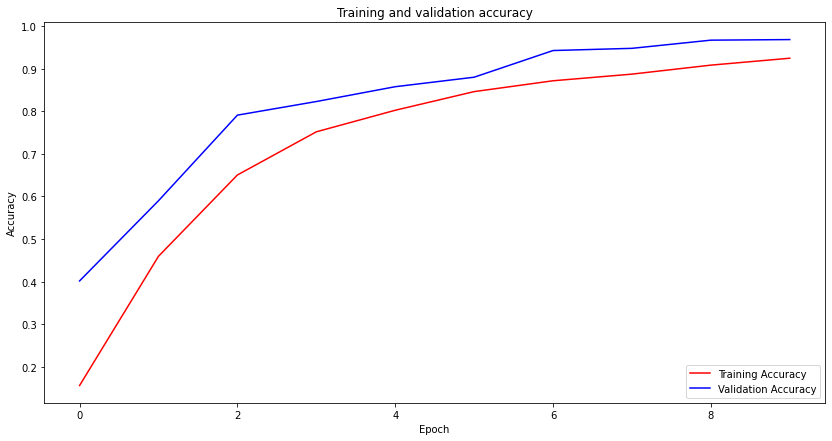

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_1l.history.history['accuracy']
val_acc= model_1_1l.history.history['val_accuracy']
loss= model_1_1l.history.history['loss']
val_loss= model_1_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

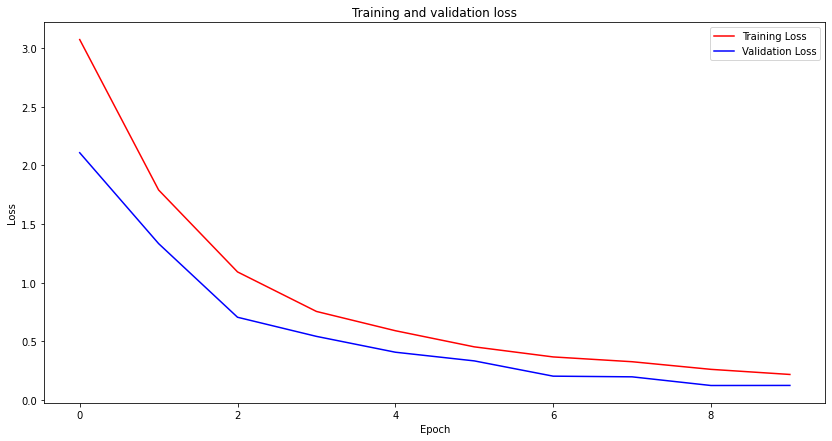

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 18s 67ms/step - loss: 0.1272 - accuracy: 0.9678
loss : 0.12719424068927765 acc : 0.9677660465240479


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 18s 67ms/step
              precision    recall  f1-score   support

           A       0.95      0.99      0.97       600
           B       0.97      0.99      0.98       600
           C       1.00      1.00      1.00       600
           D       1.00      1.00      1.00       600
           E       0.95      0.94      0.94       600
           F       1.00      0.99      1.00       600
           G       0.99      0.99      0.99       600
           H       0.99      1.00      0.99       600
           I       1.00      0.94      0.97       602
           J       1.00      0.99      1.00       600
           K       0.95      1.00      0.97       600
           L       0.99      1.00      1.00       600
           M       1.00      0.93      0.96       600
           N       0.97      0.98      0.98       602
           O       0.98      0.98      0.98       600
           P       1.00      0.97      0.98       600
           Q       0.98 

<Figure size 3600x3600 with 0 Axes>

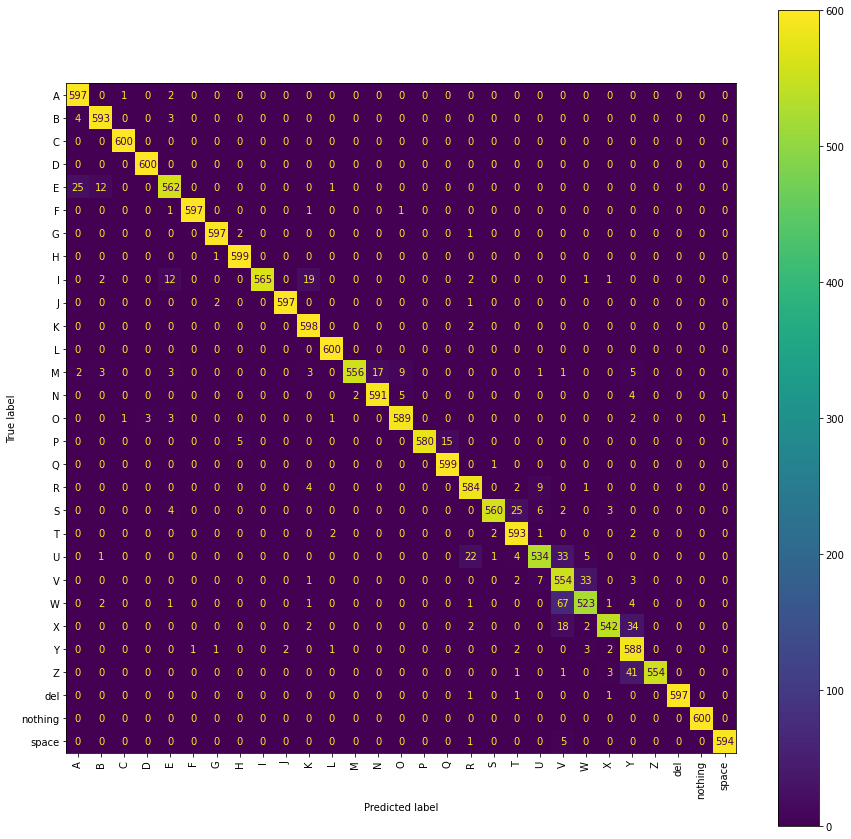

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_1l = Sequential()

model_2_1l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_1l.add(Activation('relu'))
model_2_1l.add(MaxPooling2D((2, 2)))
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Flatten())
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Dense(128, activation='swish'))

model_2_1l.add(Dense(num_classes, activation='softmax'))

model_2_1l.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_8 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 flatten_7 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_15 (Dropout)        (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 85s 89ms/step - loss: 3.1544 - accuracy: 0.1264 - val_loss: 2.4265 - val_accuracy: 0.3274
Epoch 2/10
952/952 [==============================] - 85s 89ms/step - loss: 2.1209 - accuracy: 0.3687 - val_loss: 1.5666 - val_accuracy: 0.5345
Epoch 3/10
952/952 [==============================] - 85s 89ms/step - loss: 1.4731 - accuracy: 0.5394 - val_loss: 1.0400 - val_accuracy: 0.6851
Epoch 4/10
952/952 [==============================] - 84s 88ms/step - loss: 1.0783 - accuracy: 0.6560 - val_loss: 0.7359 - val_accuracy: 0.7774
Epoch 5/10
952/952 [==============================] - 84s 89ms/step - loss: 0.8562 - accuracy: 0.7202 - val_loss: 0.5969 - val_accuracy: 0.8042
Epoch 6/10
952/952 [==============================] - 84s 88ms/step - loss: 0.6777 - accuracy: 0.7762 - val_loss: 0.4807 - val_accuracy: 0.8489
Epoch 7/10
952/952 [==============================] - 84s 88ms/step - loss: 0.5849 - accuracy: 0.8058 - val_loss: 0.3313 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.154428  0.126424  2.426473      0.327396
1  2.120940  0.368700  1.566568      0.534475
2  1.473071  0.539400  1.040015      0.685130
3  1.078278  0.655958  0.735877      0.777407
4  0.856170  0.720163  0.596868      0.804183
5  0.677672  0.776209  0.480700      0.848885
6  0.584908  0.805808  0.331302      0.901057
7  0.496044  0.833470  0.274680      0.913698
8  0.432333  0.854812  0.272107      0.910940
9  0.384937  0.869899  0.189154      0.941967

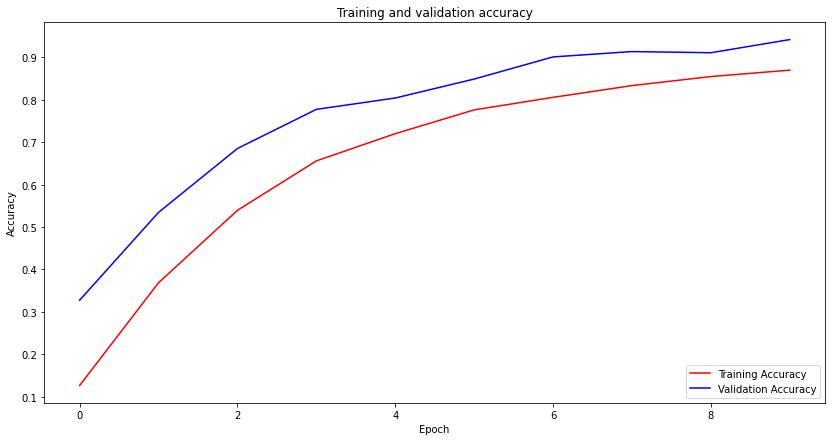

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_1l.history.history['accuracy']
val_acc= model_2_1l.history.history['val_accuracy']
loss= model_2_1l.history.history['loss']
val_loss= model_2_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

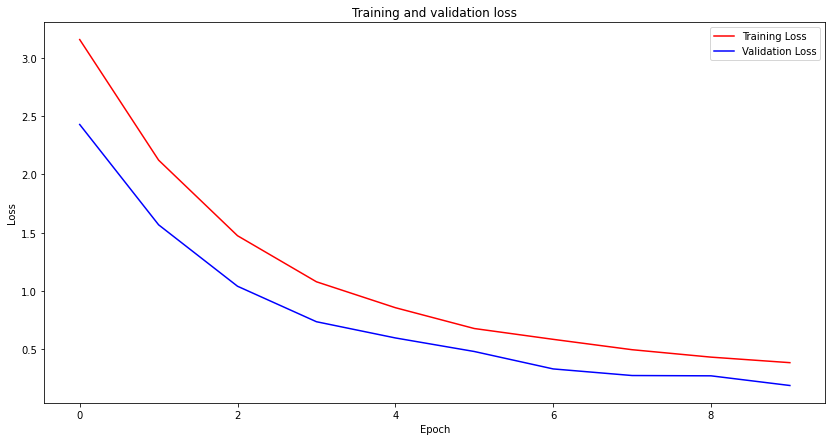

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 68ms/step - loss: 0.1935 - accuracy: 0.9431
loss : 0.19353637099266052 acc : 0.9431165456771851


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 18s 67ms/step
              precision    recall  f1-score   support

           A       0.94      0.97      0.96       600
           B       0.94      0.97      0.96       600
           C       1.00      1.00      1.00       600
           D       0.93      1.00      0.96       600
           E       1.00      0.87      0.93       600
           F       0.99      0.99      0.99       600
           G       0.98      0.97      0.98       600
           H       0.97      1.00      0.99       600
           I       1.00      0.98      0.99       602
           J       0.99      1.00      1.00       600
           K       0.93      1.00      0.96       600
           L       1.00      1.00      1.00       600
           M       0.92      0.94      0.93       600
           N       0.98      0.93      0.95       602
           O       0.99      0.91      0.95       600
           P       0.98      0.98      0.98       600
           Q       0.97 

<Figure size 3600x3600 with 0 Axes>

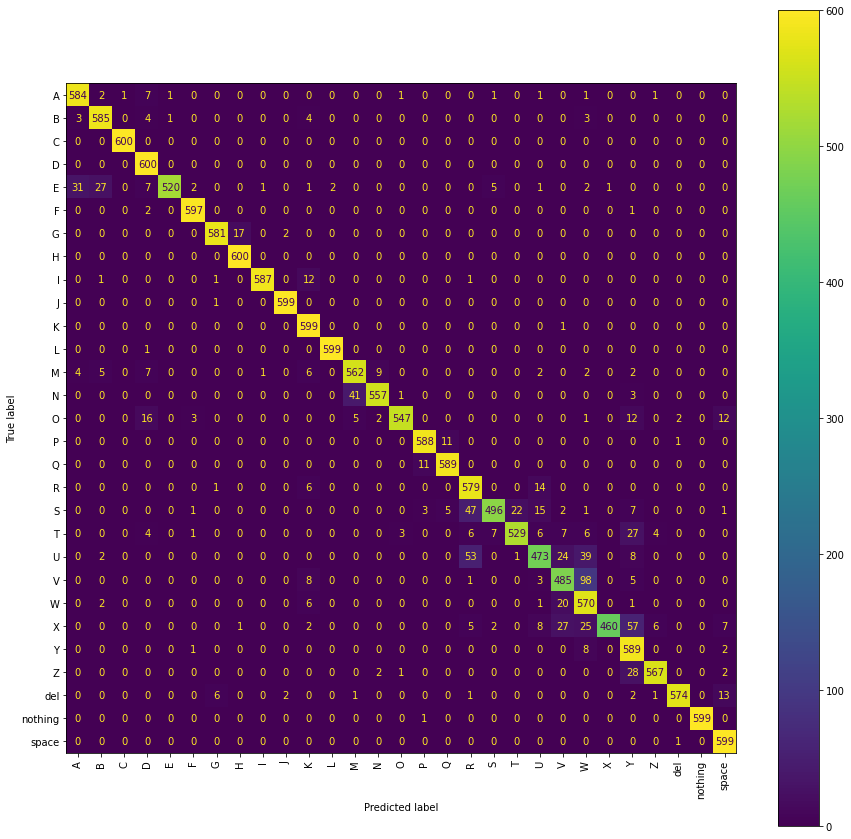

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_1l = Sequential()

model_3_1l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_1l.add(Activation('relu'))
model_3_1l.add(MaxPooling2D((2, 2)))
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Flatten())
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Dense(128, activation='swish'))

model_3_1l.add(Dense(num_classes, activation='softmax'))

model_3_1l.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 activation_9 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 flatten_8 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_17 (Dropout)        (None, 28800)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 86s 90ms/step - loss: 3.0100 - accuracy: 0.1736 - val_loss: 2.2369 - val_accuracy: 0.3514
Epoch 2/10
952/952 [==============================] - 87s 91ms/step - loss: 1.7262 - accuracy: 0.4731 - val_loss: 1.0453 - val_accuracy: 0.6670
Epoch 3/10
952/952 [==============================] - 85s 90ms/step - loss: 1.0277 - accuracy: 0.6625 - val_loss: 0.7772 - val_accuracy: 0.7460
Epoch 4/10
952/952 [==============================] - 82s 86ms/step - loss: 0.7457 - accuracy: 0.7498 - val_loss: 0.4705 - val_accuracy: 0.8585
Epoch 5/10
952/952 [==============================] - 81s 85ms/step - loss: 0.5467 - accuracy: 0.8102 - val_loss: 0.3732 - val_accuracy: 0.8923
Epoch 6/10
952/952 [==============================] - 81s 85ms/step - loss: 0.4216 - accuracy: 0.8532 - val_loss: 0.2748 - val_accuracy: 0.9084
Epoch 7/10
952/952 [==============================] - 81s 85ms/step - loss: 0.3364 - accuracy: 0.8831 - val_loss: 0.1783 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.010048  0.173573  2.236884      0.351413
1  1.726241  0.473093  1.045350      0.666973
2  1.027688  0.662524  0.777233      0.746035
3  0.745673  0.749762  0.470453      0.858538
4  0.546698  0.810241  0.373197      0.892324
5  0.421563  0.853236  0.274814      0.908412
6  0.336381  0.883065  0.178284      0.948518
7  0.285110  0.899136  0.177475      0.940014
8  0.237604  0.918344  0.160691      0.946104
9  0.208670  0.927866  0.131072      0.957596

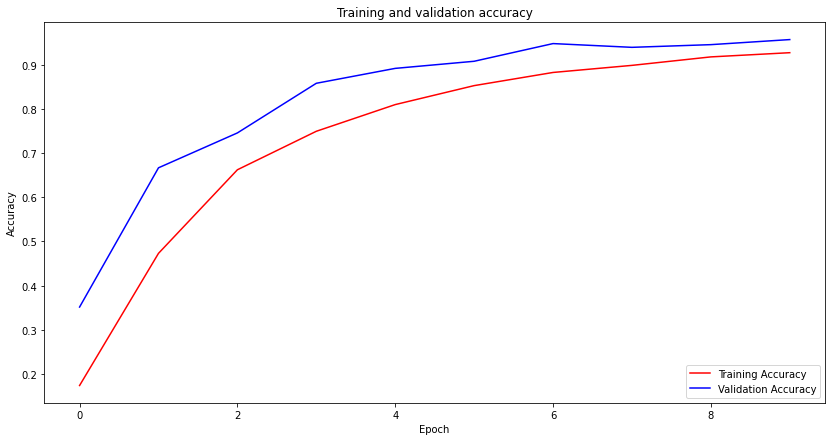

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_1l.history.history['accuracy']
val_acc= model_3_1l.history.history['val_accuracy']
loss= model_3_1l.history.history['loss']
val_loss= model_3_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

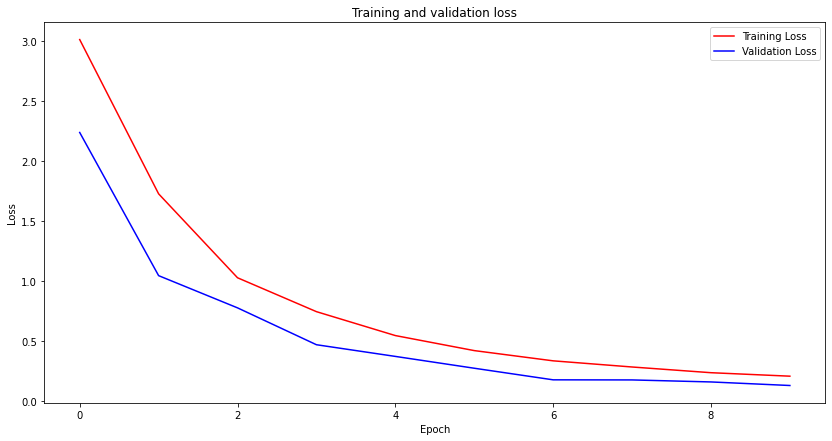

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 69ms/step - loss: 0.1309 - accuracy: 0.9577
loss : 0.1308581382036209 acc : 0.957710862159729


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 18s 66ms/step
              precision    recall  f1-score   support

           A       0.82      0.99      0.90       600
           B       0.98      0.97      0.98       600
           C       1.00      1.00      1.00       600
           D       0.99      1.00      0.99       600
           E       0.99      0.79      0.88       600
           F       1.00      0.99      1.00       600
           G       0.99      0.99      0.99       600
           H       0.99      0.99      0.99       600
           I       0.99      0.98      0.99       602
           J       1.00      1.00      1.00       600
           K       0.98      1.00      0.99       600
           L       0.99      1.00      1.00       600
           M       0.85      0.99      0.92       600
           N       1.00      0.86      0.92       602
           O       1.00      0.98      0.99       600
           P       0.92      0.99      0.96       600
           Q       1.00 

<Figure size 3600x3600 with 0 Axes>

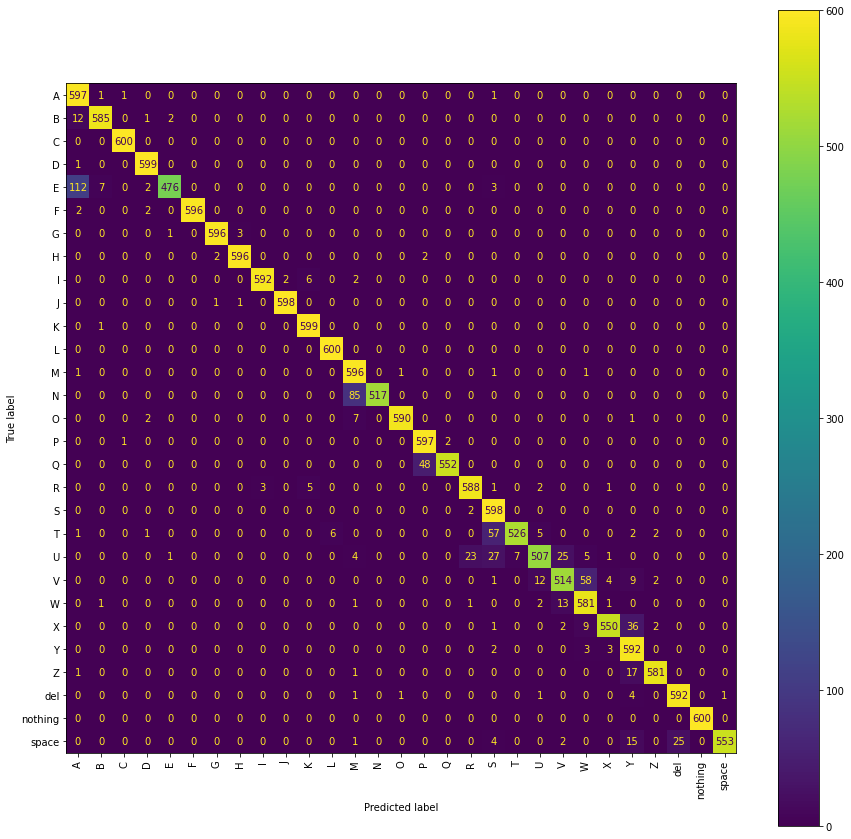

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_1l = Sequential()

model_4_1l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_1l.add(Activation('relu'))
model_4_1l.add(MaxPooling2D((2, 2)))
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Flatten())
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Dense(128, activation='swish'))

model_4_1l.add(Dense(num_classes, activation='softmax'))

model_4_1l.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 59, 59, 32)        3488      
                                                                 
 activation_10 (Activation)  (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 flatten_9 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_19 (Dropout)        (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 88s 92ms/step - loss: 3.0841 - accuracy: 0.1398 - val_loss: 2.3488 - val_accuracy: 0.3328
Epoch 2/10
952/952 [==============================] - 86s 90ms/step - loss: 1.8513 - accuracy: 0.4380 - val_loss: 1.1806 - val_accuracy: 0.6616
Epoch 3/10
952/952 [==============================] - 85s 89ms/step - loss: 1.1621 - accuracy: 0.6291 - val_loss: 0.7044 - val_accuracy: 0.8099
Epoch 4/10
952/952 [==============================] - 84s 88ms/step - loss: 0.8154 - accuracy: 0.7316 - val_loss: 0.4986 - val_accuracy: 0.8404
Epoch 5/10
952/952 [==============================] - 80s 84ms/step - loss: 0.6067 - accuracy: 0.7957 - val_loss: 0.3924 - val_accuracy: 0.8658
Epoch 6/10
952/952 [==============================] - 79s 83ms/step - loss: 0.4623 - accuracy: 0.8438 - val_loss: 0.2714 - val_accuracy: 0.9146
Epoch 7/10
952/952 [==============================] - 79s 83ms/step - loss: 0.3921 - accuracy: 0.8688 - val_loss: 0.2898 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.084100  0.139754  2.348784      0.332797
1  1.851337  0.438044  1.180624      0.661572
2  1.162085  0.629051  0.704424      0.809929
3  0.815406  0.731572  0.498626      0.840382
4  0.606737  0.795712  0.392399      0.865778
5  0.462260  0.843813  0.271447      0.914617
6  0.392111  0.868782  0.289768      0.896116
7  0.322387  0.888088  0.161979      0.947828
8  0.257755  0.910973  0.184977      0.944266
9  0.228890  0.920297  0.181746      0.943576

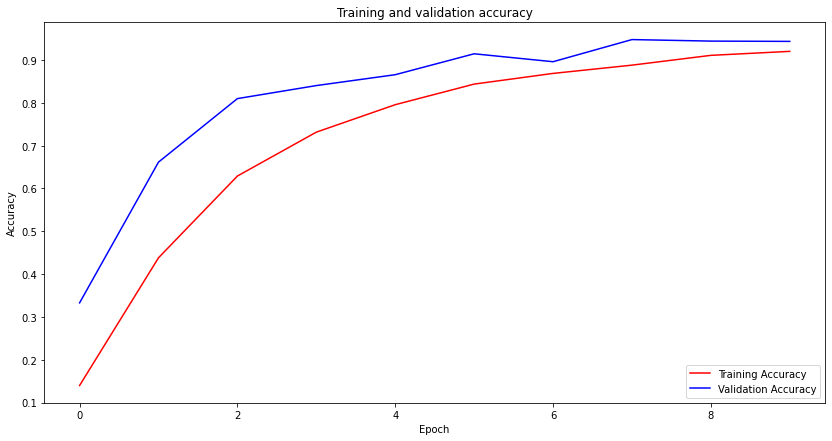

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_1l.history.history['accuracy']
val_acc= model_4_1l.history.history['val_accuracy']
loss= model_4_1l.history.history['loss']
val_loss= model_4_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

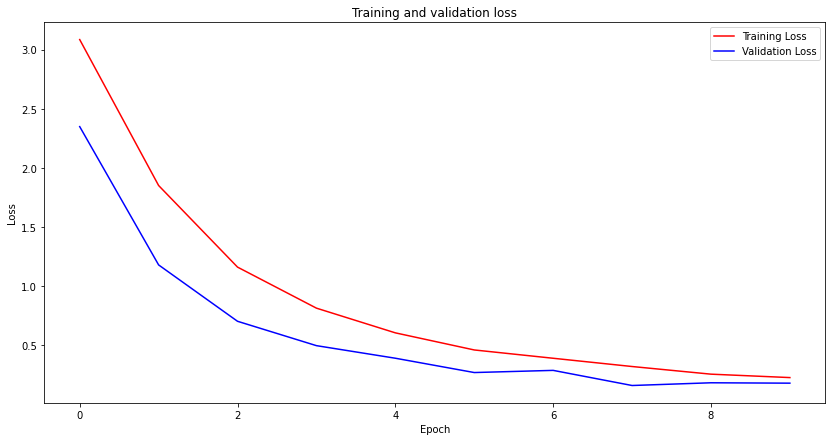

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 70ms/step - loss: 0.1842 - accuracy: 0.9406
loss : 0.18421009182929993 acc : 0.9406458139419556


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 69ms/step
              precision    recall  f1-score   support

           A       0.99      0.95      0.97       600
           B       0.97      0.97      0.97       600
           C       1.00      0.99      0.99       600
           D       0.99      0.99      0.99       600
           E       0.94      0.93      0.94       600
           F       1.00      1.00      1.00       600
           G       0.98      1.00      0.99       600
           H       1.00      0.97      0.98       600
           I       0.92      0.98      0.95       602
           J       0.98      1.00      0.99       600
           K       0.97      0.97      0.97       600
           L       1.00      1.00      1.00       600
           M       0.98      0.92      0.95       600
           N       0.99      0.91      0.95       602
           O       0.85      0.99      0.92       600
           P       0.96      0.97      0.96       600
           Q       0.97 

<Figure size 3600x3600 with 0 Axes>

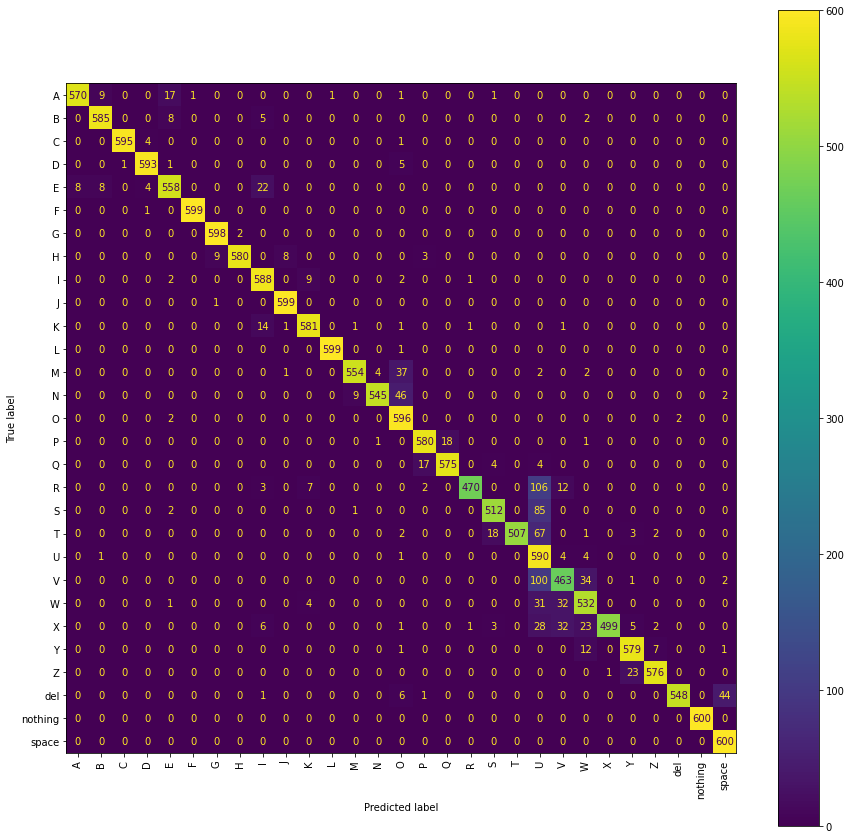

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_1l = Sequential()

model_5_1l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_1l.add(Activation('relu'))
model_5_1l.add(MaxPooling2D((2, 2)))
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Flatten())
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Dense(128, activation='swish'))

model_5_1l.add(Dense(num_classes, activation='softmax'))

model_5_1l.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 57, 57, 32)        6176      
                                                                 
 activation_11 (Activation)  (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dropout_21 (Dropout)        (None, 25088)             0         
                                                     

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 96s 100ms/step - loss: 3.3756 - accuracy: 0.0366 - val_loss: 3.2746 - val_accuracy: 0.0840
Epoch 2/10
952/952 [==============================] - 96s 101ms/step - loss: 2.9839 - accuracy: 0.1609 - val_loss: 2.4085 - val_accuracy: 0.3329
Epoch 3/10
952/952 [==============================] - 94s 98ms/step - loss: 2.1953 - accuracy: 0.3526 - val_loss: 1.6005 - val_accuracy: 0.5328
Epoch 4/10
952/952 [==============================] - 82s 86ms/step - loss: 1.6909 - accuracy: 0.4840 - val_loss: 1.2137 - val_accuracy: 0.6534
Epoch 5/10
952/952 [==============================] - 82s 86ms/step - loss: 1.3434 - accuracy: 0.5805 - val_loss: 0.9788 - val_accuracy: 0.7235
Epoch 6/10
952/952 [==============================] - 82s 86ms/step - loss: 1.0977 - accuracy: 0.6523 - val_loss: 0.7744 - val_accuracy: 0.7578
Epoch 7/10
952/952 [==============================] - 82s 86ms/step - loss: 0.9368 - accuracy: 0.6996 - val_loss: 0.6040 - val_accurac

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.375631  0.036593  3.274552      0.084004
1  2.983880  0.160899  2.408540      0.332912
2  2.195273  0.352563  1.600450      0.532751
3  1.690858  0.483961  1.213745      0.653413
4  1.343398  0.580491  0.978828      0.723512
5  1.097704  0.652280  0.774390      0.757757
6  0.936754  0.699560  0.603969      0.808320
7  0.821656  0.733953  0.487989      0.854516
8  0.729506  0.762534  0.452422      0.854401
9  0.662003  0.781774  0.380413      0.890600

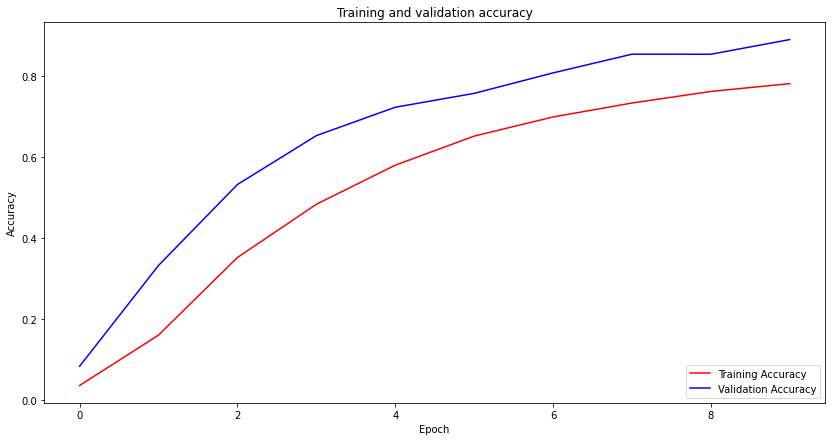

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_1l.history.history['accuracy']
val_acc= model_5_1l.history.history['val_accuracy']
loss= model_5_1l.history.history['loss']
val_loss= model_5_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

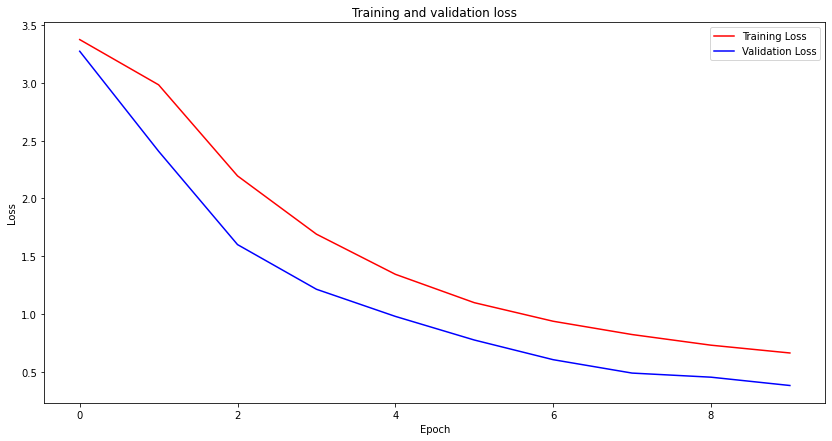

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 18s 67ms/step - loss: 0.3804 - accuracy: 0.8897
loss : 0.38043758273124695 acc : 0.8897379636764526


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 18s 66ms/step
              precision    recall  f1-score   support

           A       0.96      0.88      0.92       600
           B       0.79      0.98      0.87       600
           C       1.00      0.96      0.98       600
           D       0.95      0.96      0.96       600
           E       0.95      0.73      0.83       600
           F       0.99      0.96      0.97       600
           G       0.98      0.92      0.95       600
           H       0.93      0.99      0.96       600
           I       0.98      0.92      0.95       602
           J       0.98      0.99      0.99       600
           K       0.85      0.97      0.91       600
           L       0.96      1.00      0.98       600
           M       0.86      0.89      0.87       600
           N       0.97      0.91      0.94       602
           O       0.95      0.86      0.91       600
           P       0.98      0.75      0.85       600
           Q       0.81 

<Figure size 3600x3600 with 0 Axes>

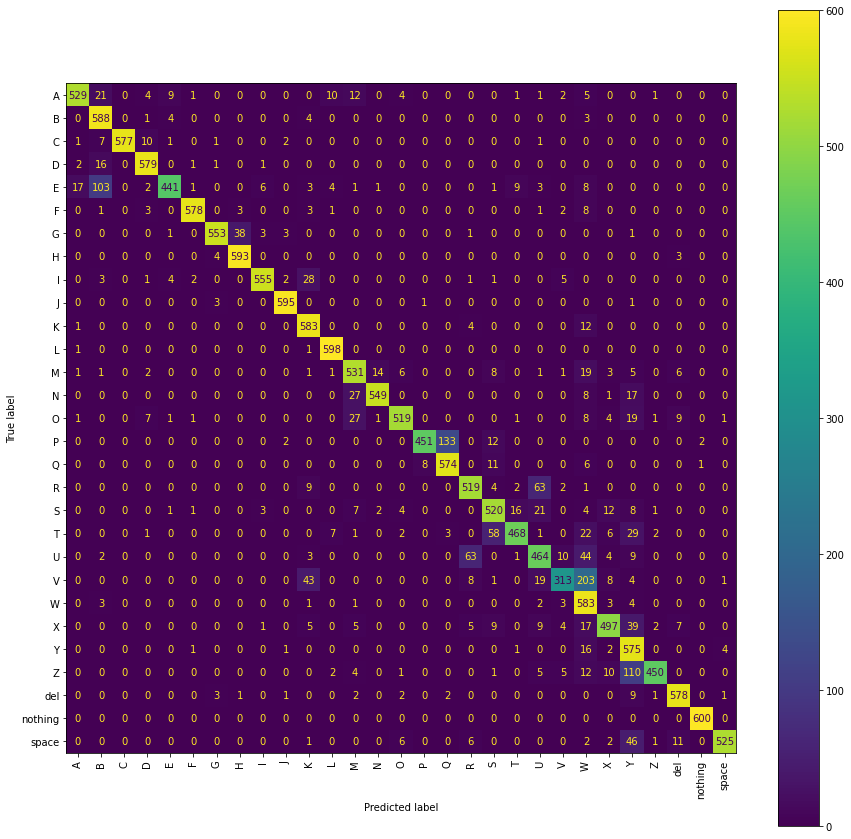

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

## **CNN Models with 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_2l = Sequential()

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Flatten())
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Dense(128, activation='swish'))

model_1_2l.add(Dense(num_classes, activation='softmax'))

model_1_2l.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 activation_12 (Activation)  (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        25632     
                                                                 
 activation_13 (Activation)  (None, 26, 26, 32)        0         
                                                     

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 86s 90ms/step - loss: 3.3791 - accuracy: 0.0261 - val_loss: 3.3677 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 85s 89ms/step - loss: 3.3732 - accuracy: 0.0173 - val_loss: 3.3680 - val_accuracy: 0.0346
Epoch 3/10
952/952 [==============================] - 85s 90ms/step - loss: 3.3777 - accuracy: 0.0265 - val_loss: 3.3650 - val_accuracy: 0.0406
Epoch 4/10
952/952 [==============================] - 86s 90ms/step - loss: 3.1758 - accuracy: 0.0998 - val_loss: 2.5698 - val_accuracy: 0.2945
Epoch 5/10
952/952 [==============================] - 89s 94ms/step - loss: 2.1715 - accuracy: 0.3594 - val_loss: 1.4558 - val_accuracy: 0.5764
Epoch 6/10
952/952 [==============================] - 91s 96ms/step - loss: 1.4162 - accuracy: 0.5525 - val_loss: 0.8404 - val_accuracy: 0.7810
Epoch 7/10
952/952 [==============================] - 87s 92ms/step - loss: 1.0009 - accuracy: 0.6769 - val_loss: 0.5520 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.379108  0.026135  3.367725      0.034475
1  3.373164  0.017254  3.367989      0.034590
2  3.377750  0.026529  3.364958      0.040565
3  3.175759  0.099813  2.569833      0.294530
4  2.171501  0.359441  1.455813      0.576419
5  1.416169  0.552451  0.840410      0.780970
6  1.000914  0.676889  0.551968      0.840152
7  0.783130  0.742046  0.377771      0.910021
8  0.643967  0.787143  0.310984      0.918065
9  0.546023  0.818416  0.252160      0.938060

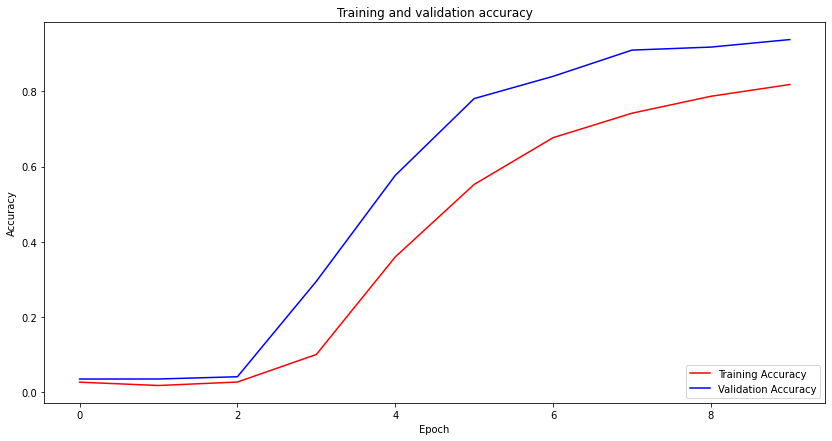

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_2l.history.history['accuracy']
val_acc= model_1_2l.history.history['val_accuracy']
loss= model_1_2l.history.history['loss']
val_loss= model_1_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

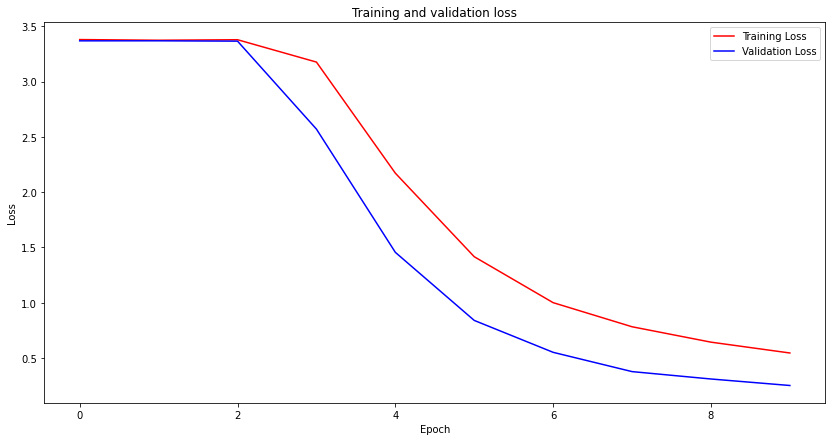

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 18s 67ms/step - loss: 0.2501 - accuracy: 0.9387
loss : 0.25006532669067383 acc : 0.9387497305870056


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 18s 67ms/step
              precision    recall  f1-score   support

           A       0.99      0.94      0.96       600
           B       0.90      0.99      0.94       600
           C       1.00      1.00      1.00       600
           D       0.99      0.99      0.99       600
           E       0.95      0.91      0.93       600
           F       0.98      1.00      0.99       600
           G       1.00      0.89      0.94       600
           H       0.88      1.00      0.93       600
           I       0.90      1.00      0.95       602
           J       0.98      0.98      0.98       600
           K       0.95      0.93      0.94       600
           L       1.00      0.97      0.99       600
           M       0.83      0.98      0.90       600
           N       1.00      0.88      0.93       602
           O       0.99      0.96      0.98       600
           P       0.93      0.98      0.96       600
           Q       0.96 

<Figure size 3600x3600 with 0 Axes>

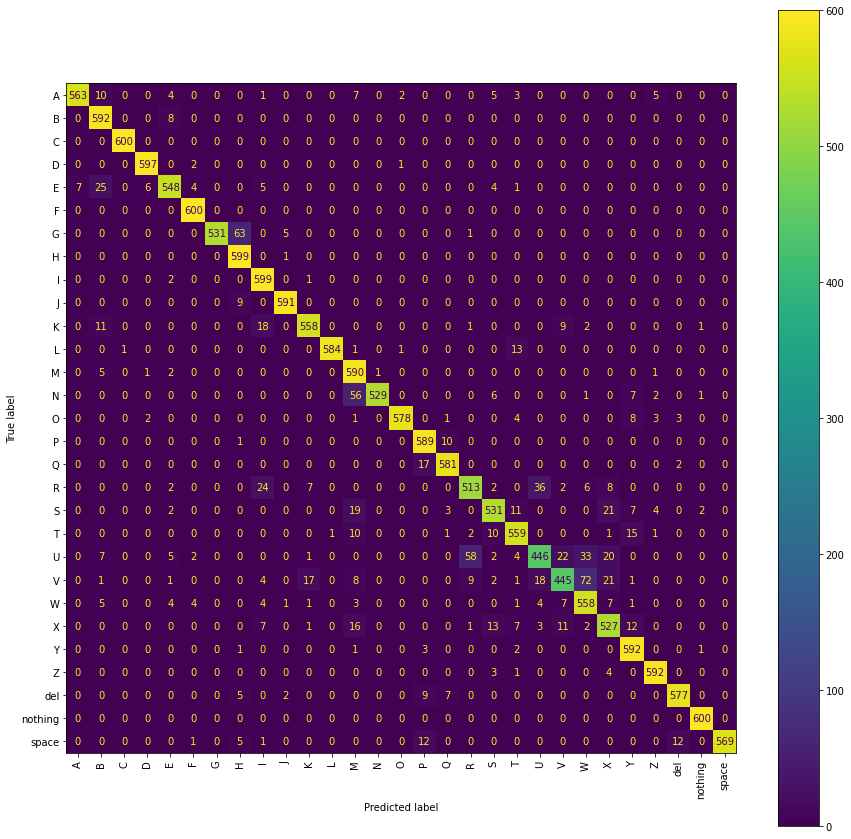

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_2l = Sequential()

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Flatten())
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Dense(128, activation='swish'))

model_2_2l.add(Dense(num_classes, activation='softmax'))

model_2_2l.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 58, 58, 32)        4736      
                                                                 
 activation_14 (Activation)  (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 23, 23, 32)        50208     
                                                                 
 activation_15 (Activation)  (None, 23, 23, 32)        0         
                                                     

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 90s 94ms/step - loss: 3.3800 - accuracy: 0.0241 - val_loss: 3.3668 - val_accuracy: 0.0322
Epoch 2/10
952/952 [==============================] - 90s 95ms/step - loss: 3.3758 - accuracy: 0.0261 - val_loss: 3.3575 - val_accuracy: 0.0554
Epoch 3/10
952/952 [==============================] - 92s 96ms/step - loss: 3.2573 - accuracy: 0.0830 - val_loss: 3.0068 - val_accuracy: 0.1821
Epoch 4/10
952/952 [==============================] - 92s 96ms/step - loss: 2.8644 - accuracy: 0.1966 - val_loss: 2.6020 - val_accuracy: 0.2864
Epoch 5/10
952/952 [==============================] - 90s 95ms/step - loss: 2.3544 - accuracy: 0.3208 - val_loss: 2.1290 - val_accuracy: 0.4151
Epoch 6/10
952/952 [==============================] - 91s 95ms/step - loss: 1.7996 - accuracy: 0.4576 - val_loss: 1.5697 - val_accuracy: 0.6172
Epoch 7/10
952/952 [==============================] - 88s 93ms/step - loss: 1.4104 - accuracy: 0.5629 - val_loss: 1.3546 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.380026  0.024149  3.366839      0.032177
1  3.375842  0.026070  3.357498      0.055390
2  3.257302  0.082986  3.006758      0.182142
3  2.864419  0.196589  2.602025      0.286371
4  2.354417  0.320846  2.128997      0.415077
5  1.799586  0.457612  1.569688      0.617214
6  1.410357  0.562925  1.354640      0.635026
7  1.163922  0.631907  1.144821      0.687428
8  1.016145  0.674820  1.010124      0.728223
9  0.909284  0.705142  0.873501      0.774879

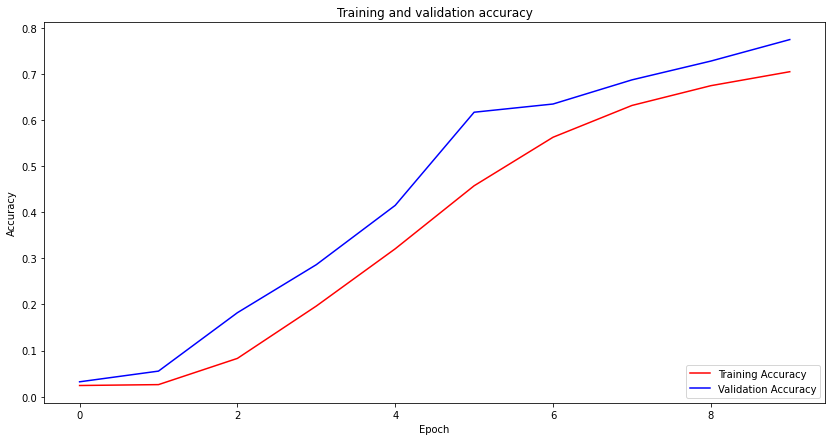

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_2l.history.history['accuracy']
val_acc= model_2_2l.history.history['val_accuracy']
loss= model_2_2l.history.history['loss']
val_loss= model_2_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

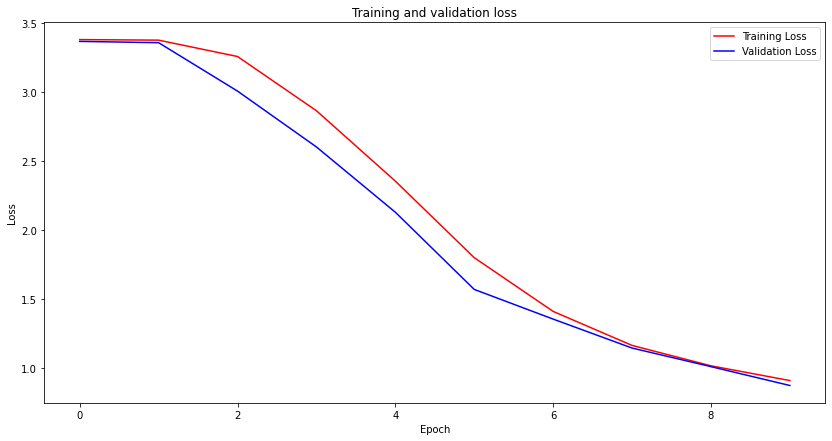

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 68ms/step - loss: 0.8601 - accuracy: 0.7838
loss : 0.8600949048995972 acc : 0.7838428020477295


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 68ms/step
              precision    recall  f1-score   support

           A       0.69      0.87      0.77       600
           B       0.94      0.76      0.84       600
           C       0.99      0.95      0.97       600
           D       0.97      0.78      0.86       600
           E       0.81      0.68      0.74       600
           F       1.00      0.80      0.89       600
           G       0.94      0.59      0.72       600
           H       0.68      0.96      0.80       600
           I       0.57      0.89      0.70       602
           J       0.97      0.82      0.89       600
           K       0.86      0.67      0.75       600
           L       0.99      0.95      0.97       600
           M       0.85      0.44      0.58       600
           N       0.69      0.73      0.71       602
           O       0.99      0.54      0.70       600
           P       0.90      0.83      0.86       600
           Q       0.97 

<Figure size 3600x3600 with 0 Axes>

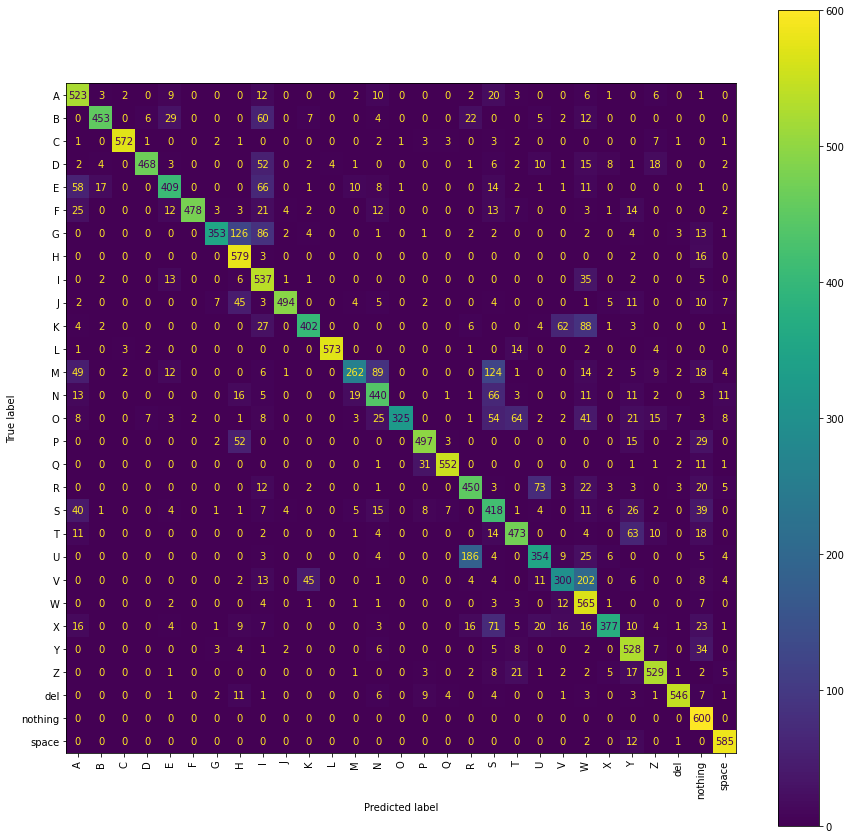

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_2l = Sequential()

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Flatten())
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Dense(128, activation='swish'))

model_3_2l.add(Dense(num_classes, activation='softmax'))

model_3_2l.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 61, 61, 32)        1568      
                                                                 
 activation_16 (Activation)  (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 27, 27, 32)        16416     
                                                                 
 activation_17 (Activation)  (None, 27, 27, 32)        0         
                                                     

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 84s 88ms/step - loss: 3.3893 - accuracy: 0.0261 - val_loss: 3.3434 - val_accuracy: 0.0456
Epoch 2/10
952/952 [==============================] - 89s 93ms/step - loss: 3.0024 - accuracy: 0.1508 - val_loss: 2.3204 - val_accuracy: 0.3357
Epoch 3/10
952/952 [==============================] - 85s 90ms/step - loss: 1.9605 - accuracy: 0.4117 - val_loss: 1.2960 - val_accuracy: 0.6225
Epoch 4/10
952/952 [==============================] - 86s 91ms/step - loss: 1.3080 - accuracy: 0.5880 - val_loss: 0.8270 - val_accuracy: 0.7471
Epoch 5/10
952/952 [==============================] - 86s 91ms/step - loss: 0.9540 - accuracy: 0.6906 - val_loss: 0.5167 - val_accuracy: 0.8668
Epoch 6/10
952/952 [==============================] - 87s 91ms/step - loss: 0.7262 - accuracy: 0.7622 - val_loss: 0.3873 - val_accuracy: 0.8875
Epoch 7/10
952/952 [==============================] - 90s 94ms/step - loss: 0.5881 - accuracy: 0.8047 - val_loss: 0.2916 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.389318  0.026070  3.343391      0.045622
1  3.002450  0.150803  2.320401      0.335670
2  1.960507  0.411695  1.295990      0.622501
3  1.307995  0.587993  0.826961      0.747070
4  0.954018  0.690629  0.516688      0.866812
5  0.726177  0.762173  0.387337      0.887497
6  0.588137  0.804675  0.291649      0.917950
7  0.490251  0.835588  0.246973      0.933349
8  0.430852  0.854254  0.205109      0.945989
9  0.381635  0.871310  0.131719      0.968053

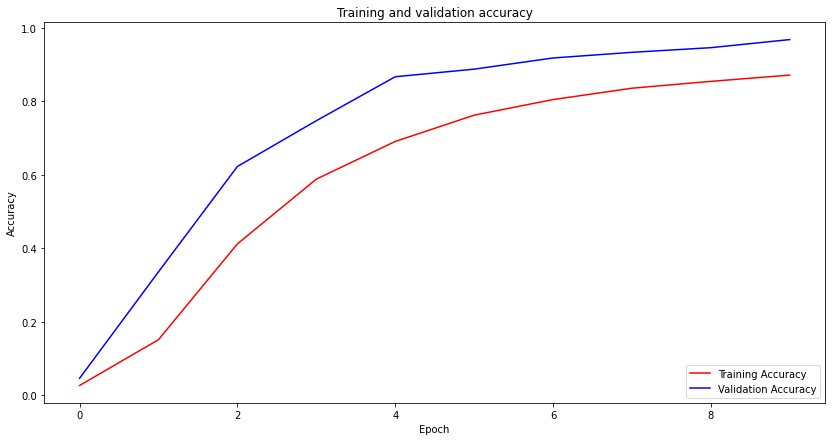

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_2l.history.history['accuracy']
val_acc= model_3_2l.history.history['val_accuracy']
loss= model_3_2l.history.history['loss']
val_loss= model_3_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

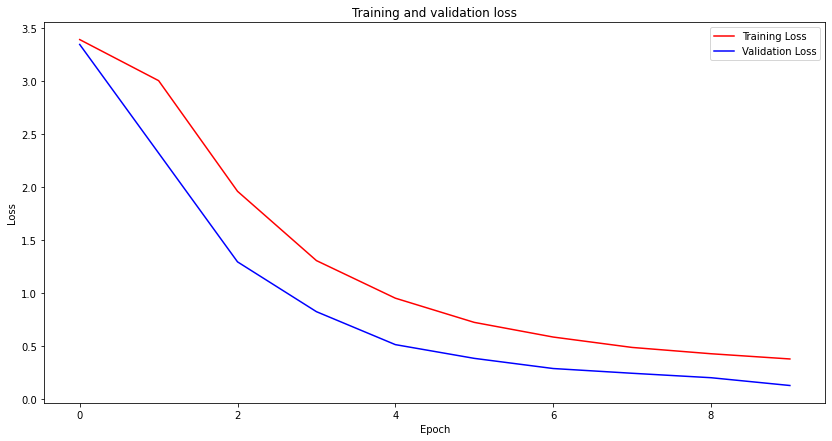

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 68ms/step - loss: 0.1262 - accuracy: 0.9708
loss : 0.12622331082820892 acc : 0.9707538485527039


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 68ms/step
              precision    recall  f1-score   support

           A       0.99      0.97      0.98       600
           B       0.94      0.99      0.96       600
           C       1.00      1.00      1.00       600
           D       0.97      1.00      0.99       600
           E       0.98      0.93      0.96       600
           F       1.00      1.00      1.00       600
           G       1.00      0.97      0.99       600
           H       0.97      0.99      0.98       600
           I       0.99      0.99      0.99       602
           J       0.98      1.00      0.99       600
           K       0.98      0.99      0.99       600
           L       1.00      1.00      1.00       600
           M       0.92      0.98      0.95       600
           N       0.99      0.90      0.94       602
           O       0.99      0.99      0.99       600
           P       1.00      1.00      1.00       600
           Q       1.00 

<Figure size 3600x3600 with 0 Axes>

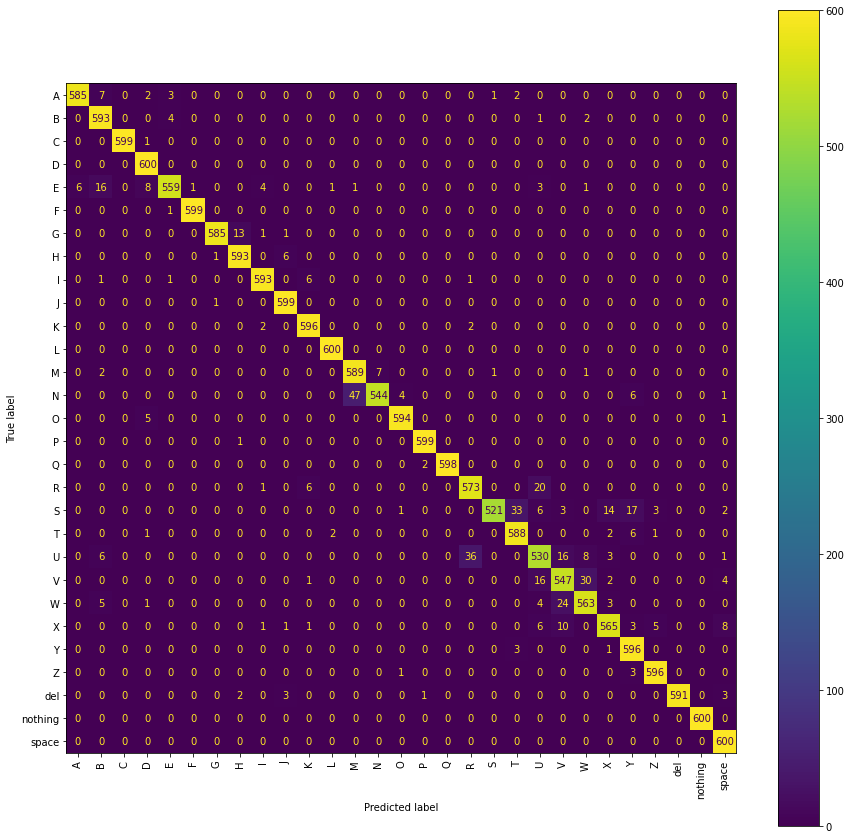

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_2l = Sequential()

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Flatten())
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Dense(128, activation='swish'))

model_4_2l.add(Dense(num_classes, activation='softmax'))

model_4_2l.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 59, 59, 32)        3488      
                                                                 
 activation_18 (Activation)  (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 32)        36896     
                                                                 
 activation_19 (Activation)  (None, 24, 24, 32)        0         
                                                     

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 92s 96ms/step - loss: 3.3804 - accuracy: 0.0285 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 90s 94ms/step - loss: 3.3730 - accuracy: 0.0240 - val_loss: 3.3676 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 89s 94ms/step - loss: 3.3726 - accuracy: 0.0284 - val_loss: 3.3678 - val_accuracy: 0.0345
Epoch 4/10
952/952 [==============================] - 91s 95ms/step - loss: 3.3783 - accuracy: 0.0266 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 5/10
952/952 [==============================] - 90s 94ms/step - loss: 3.3722 - accuracy: 0.0241 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 6/10
952/952 [==============================] - 91s 96ms/step - loss: 3.3725 - accuracy: 0.0223 - val_loss: 3.3677 - val_accuracy: 0.0345
Epoch 7/10
952/952 [==============================] - 89s 93ms/step - loss: 3.3724 - accuracy: 0.0242 - val_loss: 3.3676 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.380403  0.028532  3.367459      0.034475
1  3.372958  0.023985  3.367642      0.034475
2  3.372607  0.028450  3.367751      0.034475
3  3.378266  0.026562  3.367442      0.034475
4  3.372230  0.024050  3.367517      0.034475
5  3.372493  0.022261  3.367680      0.034475
6  3.372417  0.024165  3.367623      0.034475
7  3.372825  0.022918  3.367455      0.034475
8  3.371922  0.016827  3.367648      0.034475
9  3.372144  0.022376  3.367515      0.034475

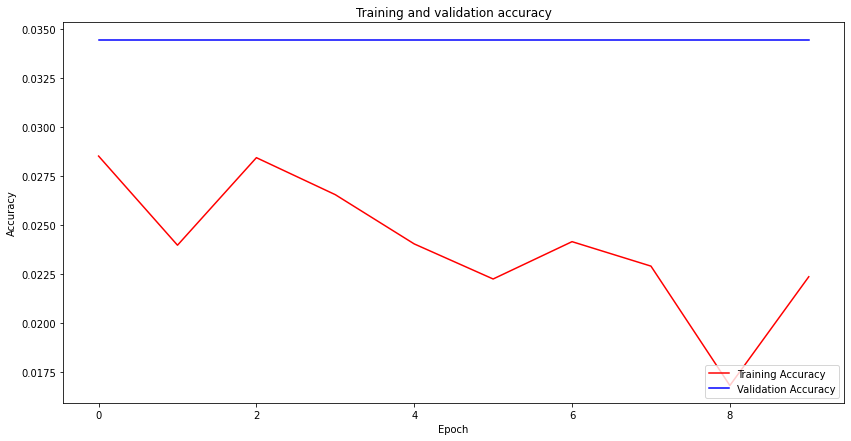

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_2l.history.history['accuracy']
val_acc= model_4_2l.history.history['val_accuracy']
loss= model_4_2l.history.history['loss']
val_loss= model_4_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

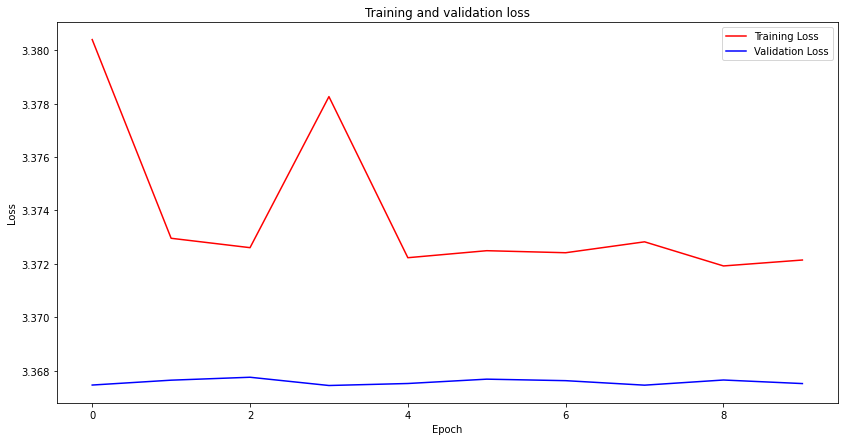

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 18s 67ms/step - loss: 3.3675 - accuracy: 0.0345
loss : 3.36751389503479 acc : 0.03447483479976654


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 18s 67ms/step
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       600
           B       0.00      0.00      0.00       600
           C       0.00      0.00      0.00       600
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       600
           F       0.00      0.00      0.00       600
           G       0.03      1.00      0.07       600
           H       0.00      0.00      0.00       600
           I       0.00      0.00      0.00       602
           J       0.00      0.00      0.00       600
           K       0.00      0.00      0.00       600
           L       0.00      0.00      0.00       600
           M       0.00      0.00      0.00       600
           N       0.00      0.00      0.00       602
           O       0.00      0.00      0.00       600
           P       0.00      0.00      0.00       600
           Q       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 3600x3600 with 0 Axes>

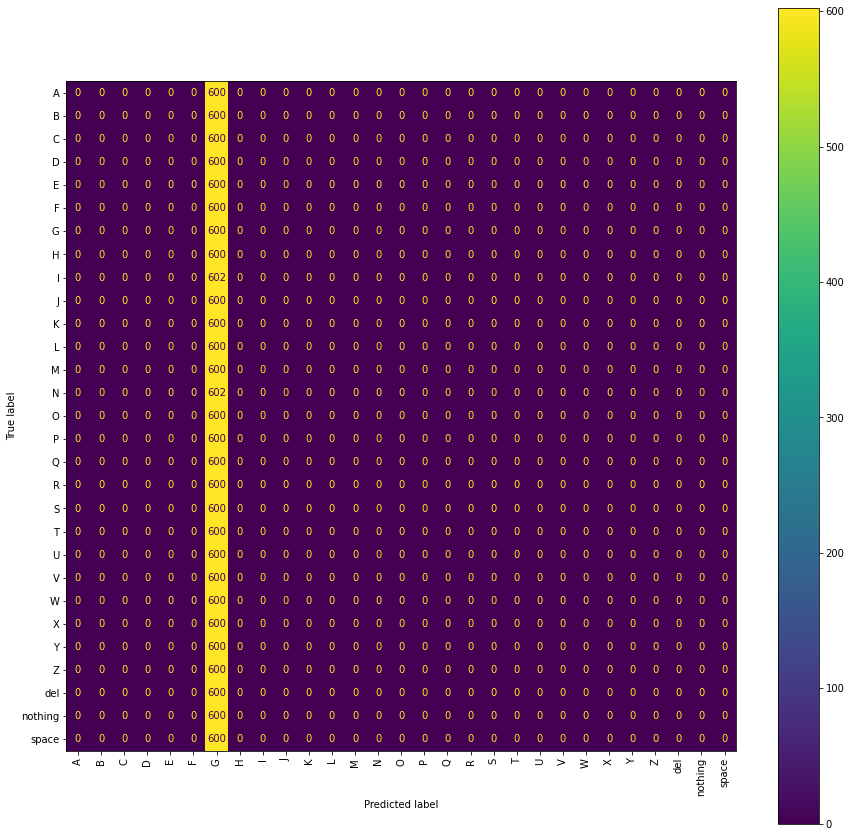

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_2l = Sequential()

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Flatten())
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Dense(128, activation='swish'))

model_5_2l.add(Dense(num_classes, activation='softmax'))

model_5_2l.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 57, 57, 32)        6176      
                                                                 
 activation_20 (Activation)  (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 21, 21, 32)        65568     
                                                                 
 activation_21 (Activation)  (None, 21, 21, 32)        0         
                                                     

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 95s 99ms/step - loss: 3.3752 - accuracy: 0.0206 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 94s 99ms/step - loss: 3.3754 - accuracy: 0.0256 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 94s 98ms/step - loss: 3.3722 - accuracy: 0.0194 - val_loss: 3.3678 - val_accuracy: 0.0345
Epoch 4/10
952/952 [==============================] - 94s 98ms/step - loss: 3.3730 - accuracy: 0.0311 - val_loss: 3.3676 - val_accuracy: 0.0346
Epoch 5/10
952/952 [==============================] - 94s 99ms/step - loss: 3.3725 - accuracy: 0.0292 - val_loss: 3.3679 - val_accuracy: 0.0345
Epoch 6/10
952/952 [==============================] - 95s 100ms/step - loss: 3.3722 - accuracy: 0.0259 - val_loss: 3.3679 - val_accuracy: 0.0345
Epoch 7/10
952/952 [==============================] - 94s 99ms/step - loss: 3.3726 - accuracy: 0.0241 - val_loss: 3.3674 - val_accuracy

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.375243  0.020619  3.367464      0.034475
1  3.375425  0.025626  3.367375      0.034475
2  3.372211  0.019388  3.367844      0.034475
3  3.373023  0.031126  3.367577      0.034590
4  3.372495  0.029156  3.367859      0.034475
5  3.372248  0.025905  3.367903      0.034475
6  3.372584  0.024067  3.367408      0.034475
7  3.372192  0.031848  3.367518      0.034475
8  3.371912  0.028154  3.367882      0.034475
9  3.372917  0.019092  3.367387      0.034475

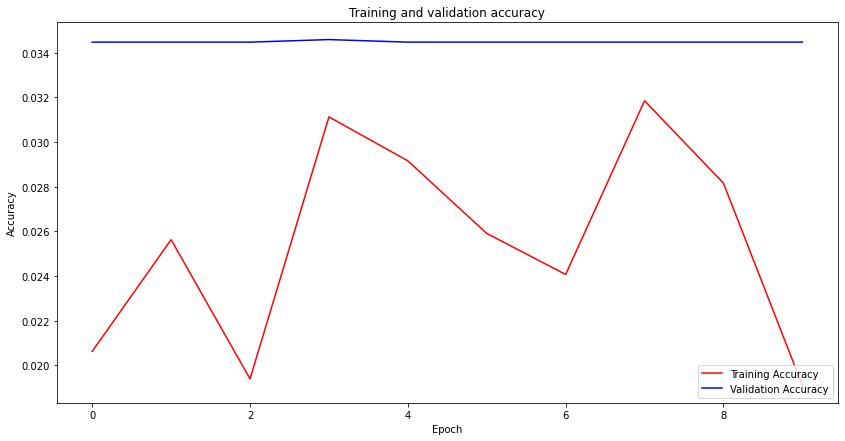

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_2l.history.history['accuracy']
val_acc= model_5_2l.history.history['val_accuracy']
loss= model_5_2l.history.history['loss']
val_loss= model_5_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

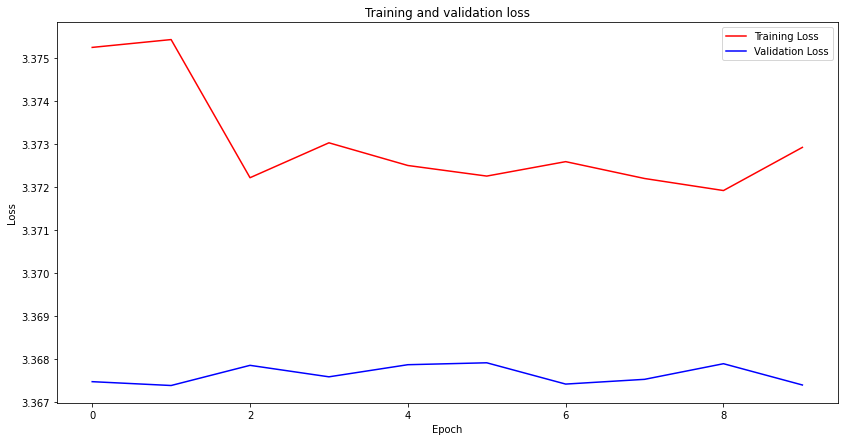

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 18s 68ms/step - loss: 3.3674 - accuracy: 0.0345
loss : 3.3673808574676514 acc : 0.03447483479976654


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 18s 68ms/step
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       600
           B       0.00      0.00      0.00       600
           C       0.00      0.00      0.00       600
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       600
           F       0.00      0.00      0.00       600
           G       0.00      0.00      0.00       600
           H       0.00      0.00      0.00       600
           I       0.00      0.00      0.00       602
           J       0.03      1.00      0.07       600
           K       0.00      0.00      0.00       600
           L       0.00      0.00      0.00       600
           M       0.00      0.00      0.00       600
           N       0.00      0.00      0.00       602
           O       0.00      0.00      0.00       600
           P       0.00      0.00      0.00       600
           Q       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 3600x3600 with 0 Axes>

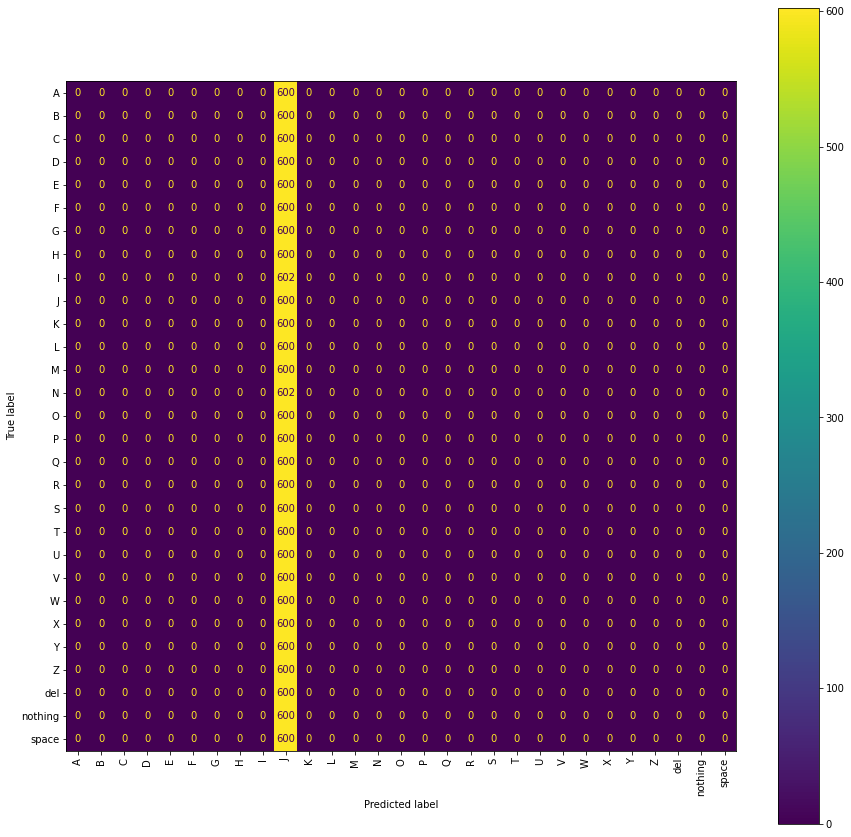

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')